<a href="https://colab.research.google.com/github/letianzj/QuantResearch/blob/master/notebooks/tensorflow_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import tensorflow as tf

### 0. Data Preparation

In [73]:
tf.random.set_seed(0)
np.random.seed(0)


sample_size = 500
batch_size = 50
sigma_e = 3.0             # true value of parameter error sigma
xs = 100 * np.random.rand(sample_size)
es = np.random.normal(0, sigma_e, sample_size)
ys = 1.0 + 2.0 * xs + es

ds = tf.data.Dataset.from_tensor_slices((xs, ys)).shuffle(buffer_size=sample_size).batch(batch_size)
for x, y in ds.take(1):         # take first batch
    print(x, y)

tf.Tensor(
[94.53015335 42.40889884 42.40322519 84.90383084 43.44166256  2.01075462
 55.20782767 40.71832972 49.04588086 10.20448107 70.44144019 21.68969844
 58.67843465 71.63272041 13.14827993 92.92961976 61.69339969 94.93188224
 60.63932141 14.94483047 94.02096894 97.6459465   8.110139    3.91877923
 95.9166603  79.17250381 53.61774947 96.89717047 41.466194   55.21924699
 29.61401975 70.65747063 43.86015135 45.18216827 82.21177332 90.65554992
 86.38556059 30.15986345 84.80082293 13.12893285 14.33532874 28.17301058
 12.89262977 31.85689525  6.41474963 17.96036776 96.15701545 61.3965956
 36.85846061 65.31083255], shape=(50,), dtype=float64) tf.Tensor(
[189.93610426  85.85229439  84.8538211  170.60625922  86.47141214
   3.74855637 115.39504027  81.28272318  97.11208653  21.64374268
 139.69574641  43.72920247 114.67828072 145.75344366  27.19127433
 189.84242269 124.75796512 187.07455944 126.40353502  30.10472459
 192.50448996 194.88530044  24.36251405   5.90106887 192.90715698
 161.91877

### 1. Low-Level Implementattion

In [138]:
w = tf.Variable(tf.random.normal(shape=[1], dtype=tf.float64))      # scaler, shape=[] or shape=[1,]
b = tf.Variable(0,  dtype = tf.float64)          # scaler

epochs = 100
learning_rate = 0.0001
ws = []
bs = []
for epoch in tf.range(1,epochs+1):      # for each epoch
  for x, y in ds:           # for each batch
    with tf.GradientTape() as tape:
      y_bar = x*w + b                    # broadcasting
      loss = tf.reduce_mean( (y-y_bar)**2 )
    # Back propagation to calculate gradient
    dloss_dw, dloss_db = tape.gradient(loss, [w, b])
    # apply_gradients
    w.assign(w - learning_rate * dloss_dw)         # assign, keeps tf.Variable; operator ==> tf.Tensor
    b.assign(b - learning_rate * dloss_db)
    ws.append(w.numpy())
    bs.append(b.numpy())
  
  if epoch%20==0:
    tf.print('w=', w, ' ,b=', b, ' ,mse=', loss)

w= [2.0112712928890448]  ,b= 0.037014469356275913  ,mse= 5.4003719993922941
w= [2.0017285954880388]  ,b= 0.043182040136795843  ,mse= 9.984350775427826
w= [2.0173304169979653]  ,b= 0.049642661606266715  ,mse= 10.609577760393805
w= [2.0192195726647]  ,b= 0.055903282183172094  ,mse= 10.622495495541957
w= [2.0075450173503664]  ,b= 0.061821160045551958  ,mse= 9.0607410309822285


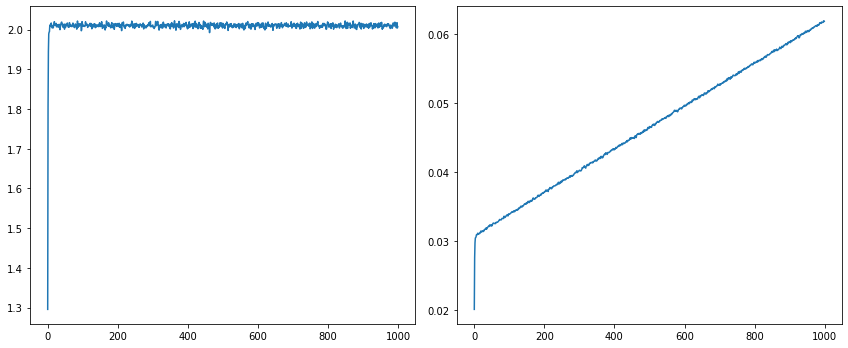

In [143]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig.tight_layout()
axes[0].plot(ws)
axes[1].plot(bs)

### 2. High-Level Implementation

In [170]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(1,input_shape =(1,)))        # total param # = 2
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [171]:
loss_fn = tf.keras.losses.mean_squared_error
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["mae"])

We can either mix it with low-level api

In [178]:
epochs = 200

for epoch in tf.range(1,epochs+1):      # for each epoch
  loss = tf.constant(0.0)
  for x, y in ds:           # for each batch
    with tf.GradientTape() as tape:
      y_bar = model(y)                # __call__
      loss = loss_fn(tf.reshape(y, [-1]), tf.reshape(y_bar, [-1]))
    # Back propagation to calculate gradient
    grads = tape.gradient(loss, model.variables)
    # apply_gradients
    model.optimizer.apply_gradients(zip(grads, model.variables))
  
  if epoch%20==0:
    tf.print('w=', w, ' ,b=', b, ' ,mse=', loss)

w= [2.0075450173503664]  ,b= 0.061821160045551958  ,mse= 2703.4873
w= [2.0075450173503664]  ,b= 0.061821160045551958  ,mse= 444.380676
w= [2.0075450173503664]  ,b= 0.061821160045551958  ,mse= 127.56617
w= [2.0075450173503664]  ,b= 0.061821160045551958  ,mse= 19.7455502
w= [2.0075450173503664]  ,b= 0.061821160045551958  ,mse= 3.22179842
w= [2.0075450173503664]  ,b= 0.061821160045551958  ,mse= 0.37601757
w= [2.0075450173503664]  ,b= 0.061821160045551958  ,mse= 0.0743840709
w= [2.0075450173503664]  ,b= 0.061821160045551958  ,mse= 0.0342200287
w= [2.0075450173503664]  ,b= 0.061821160045551958  ,mse= 0.0366197675
w= [2.0075450173503664]  ,b= 0.061821160045551958  ,mse= 0.0313969925


Or just call model.fit

In [182]:
model.reset_states()
model.fit(tf.convert_to_tensor(xs), tf.convert_to_tensor(ys), batch_size = 50, epochs = 200, verbose=0) 
tf.print('w=', model.layers[0].kernel, ' b=', model.layers[0].bias)

w= [[1.99814212]]  b= [0.820694864]
